# **Skin Cancer Classification CNN Analysis**

##**Importing the Libraries Required**

In [ ]:
import torch
from torch import nn, optim
from torch.optim import Adam
from torch.utils.data import random_split, DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import pyarrow.parquet as pq
import pandas as pd
import io
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


##**Setting Library Seeds for Reproducibility**

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
seed_everything(464)

##**Preparing the Dataset**

In [ ]:
!unzip -oq /content/drive/MyDrive/cancer_dataset.zip

##**Implementing a Custom Dataset**



In [ ]:
class CancerDataset(Dataset):
    def __init__(self, parquet_file):
        """
        Args:
            parquet_file (str): Path to the Parquet file containing the dataset.
                                The dataset should have two columns: 'bytes' (image data) and 'label'.
        """
        data = pd.read_parquet(parquet_file).values

        self.image_bytes_list = [
            entry[0]["bytes"] if isinstance(entry[0], dict) else entry[0]
            for entry in data
        ]
        self.class_list = [entry[1] for entry in data]

        self.transform = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

    def __len__(self):
        return len(self.image_bytes_list)

    def __getitem__(self, data_id):
        """
        Fetches the image and label for a given index.
        """
        image_bytes = self.image_bytes_list[data_id]
        image_class = self.class_list[data_id]

        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        image_tensor = self.transform(image)

        return image_class, image_tensor

In [ ]:
train_dataset = CancerDataset("/content/balanced_skin_cancer_dataset_train_2.parquet")
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_ratio = 0.125
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
val_dataloader = DataLoader(val_subset, batch_size=128, shuffle=False)

test_dataset = CancerDataset("/content/balanced_skin_cancer_dataset_test.parquet")
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

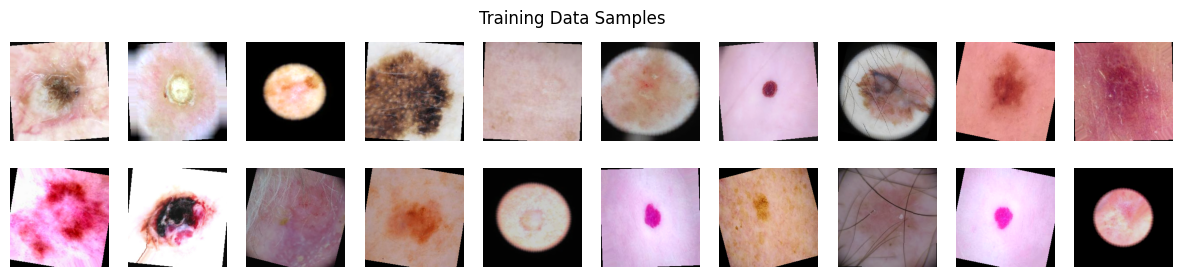

In [ ]:
_, images = next(iter(train_dataloader))
images = images.numpy()

num_rows = 2
num_columns = 10

figure, axis_array = plt.subplots(
    num_rows, num_columns, figsize=(num_columns * 1.5, num_rows * 1.5)
)
figure.suptitle("Training Data Samples")

im_id = 0
for row_id in range(num_rows):
    for column_id in range(num_columns):
        # The channel dimension of the image is moved to the last index
        # to make the shape of the image compatible with Matplotlib
        image = images[im_id].transpose(1, 2, 0)
        # Value range is mapped from [-1,1] to [0,1]
        image = (image + 1) / 2
        if num_rows == 1:
            current_axis = axis_array[column_id]
        else:
            current_axis = axis_array[row_id, column_id]
        current_axis.axis("off")
        current_axis.imshow(image)
        im_id += 1

##**Constructing a Classifier Network**

In [ ]:
class CancerClassifier(nn.Module):
    def __init__(self):
        super(CancerClassifier, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 16x112x112
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32x56x56
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64x28x28
        )

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128x14x14
        )

        self.flatten = nn.Flatten()

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=25088, out_features=64),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features=64, out_features=8),
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.flatten(x)
        x = self.fc_layers(x)

        return x

##**Implementing the Training Loop**


In [ ]:
loss_func = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CancerClassifier().to(device)
optimizer = Adam(model.parameters(), lr=2e-2)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

best_val_loss = float("inf")
patience_counter = 0
patience_limit = 8

##**Evaluating the Model**

In [ ]:
def display_evaluation_metrics():
    model.eval()

    pred_class_list = []
    gt_class_list = []

    with torch.no_grad():
        for batch_image_class, batch_image_tensor in test_dataloader:
            if torch.cuda.is_available():
                batch_image_tensor = batch_image_tensor.cuda()
                batch_image_class = batch_image_class.cuda()

            batch_outputs = model(batch_image_tensor)

            batch_image_class = batch_image_class.cpu().numpy()
            batch_outputs = batch_outputs.cpu().numpy()
            pred_classes = np.argmax(batch_outputs, axis=1)

            pred_class_list.extend(pred_classes)
            gt_class_list.extend(batch_image_class)

    accuracy = accuracy_score(gt_class_list, pred_class_list)
    print(f"Accuracy: {accuracy:.4f}")

    print(classification_report(gt_class_list, pred_class_list))

    cm = confusion_matrix(gt_class_list, pred_class_list)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

##**Plotting the Training Loss Curves**

In [ ]:
def plot_training_loss(num_epochs, val_losses, train_losses):
  plt.plot(
    range(1, num_epochs + 1),
    train_losses,
    label="Train Loss",
    color="tab:blue",
    linewidth=2,
  )
  plt.plot(
      range(1, num_epochs + 1),
      val_losses,
      label="Validation Loss",
      color="tab:orange",
      linewidth=2,
  )
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training and Validation Loss per Epoch")
  plt.legend()
  plt.grid()
  plt.show()

Epoch 1/400 - Train Loss: 1.7336 - Val Loss: 1.8397 - LR: 0.020000
Accuracy: 0.3056
              precision    recall  f1-score   support

           0       0.38      0.10      0.15       524
           1       0.33      0.17      0.22       524
           2       0.27      0.14      0.18       524
           3       0.44      0.15      0.22       524
           4       0.15      0.47      0.23       524
           5       0.31      0.62      0.41       524
           6       0.30      0.16      0.21       524
           7       0.80      0.66      0.72       524

    accuracy                           0.31      4192
   macro avg       0.37      0.31      0.29      4192
weighted avg       0.37      0.31      0.29      4192



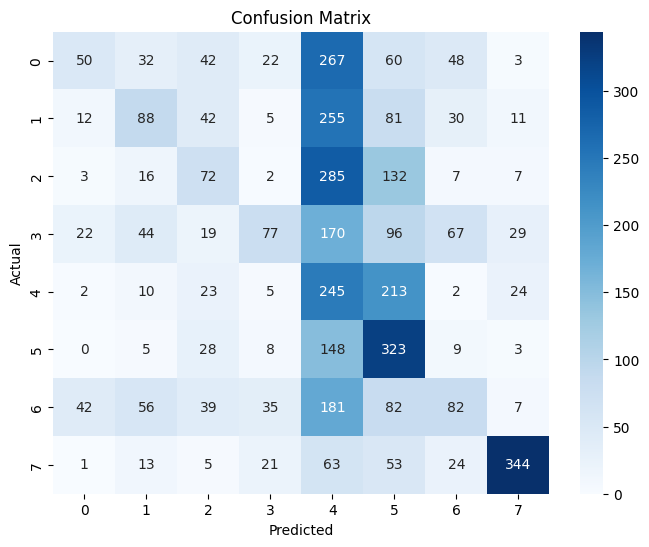

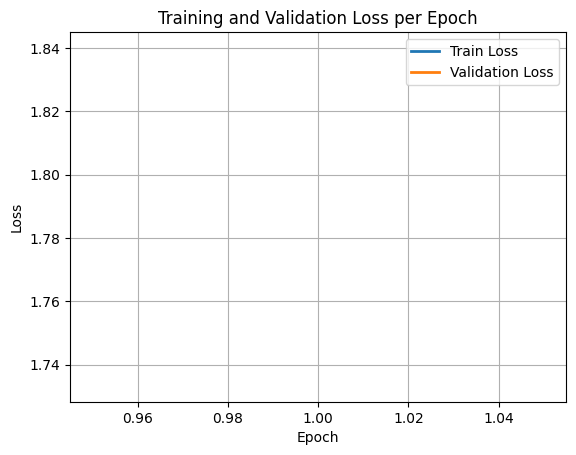

Epoch 2/400 - Train Loss: 1.7131 - Val Loss: 1.9201 - LR: 0.020000
No improvement for 1 epochs.
Epoch 3/400 - Train Loss: 1.6633 - Val Loss: 1.6370 - LR: 0.020000
Epoch 4/400 - Train Loss: 1.6230 - Val Loss: 1.6422 - LR: 0.020000
No improvement for 1 epochs.
Epoch 5/400 - Train Loss: 1.5820 - Val Loss: 1.6327 - LR: 0.020000
Epoch 6/400 - Train Loss: 1.5572 - Val Loss: 1.4941 - LR: 0.020000
Epoch 7/400 - Train Loss: 1.5106 - Val Loss: 1.5653 - LR: 0.020000
No improvement for 1 epochs.
Epoch 8/400 - Train Loss: 1.4875 - Val Loss: 1.5294 - LR: 0.020000
No improvement for 2 epochs.
Epoch 9/400 - Train Loss: 1.4492 - Val Loss: 1.5986 - LR: 0.020000
No improvement for 3 epochs.
Epoch 10/400 - Train Loss: 1.4321 - Val Loss: 1.4027 - LR: 0.020000
Epoch 11/400 - Train Loss: 1.4176 - Val Loss: 1.4570 - LR: 0.020000
Accuracy: 0.4222
              precision    recall  f1-score   support

           0       0.35      0.43      0.38       524
           1       0.62      0.15      0.25       524
   

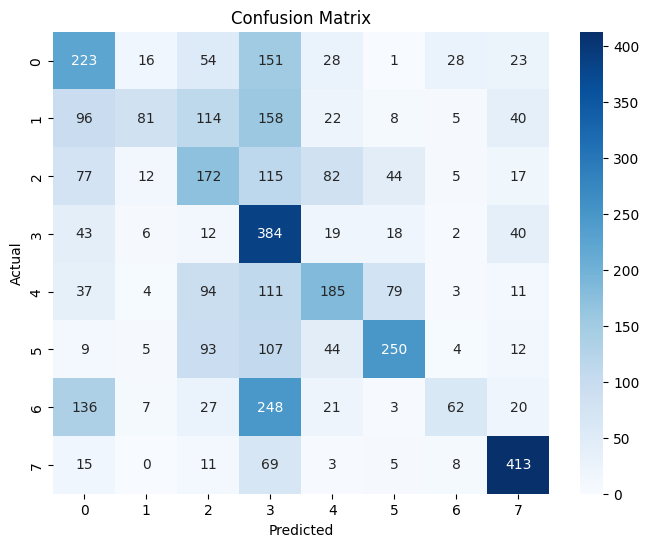

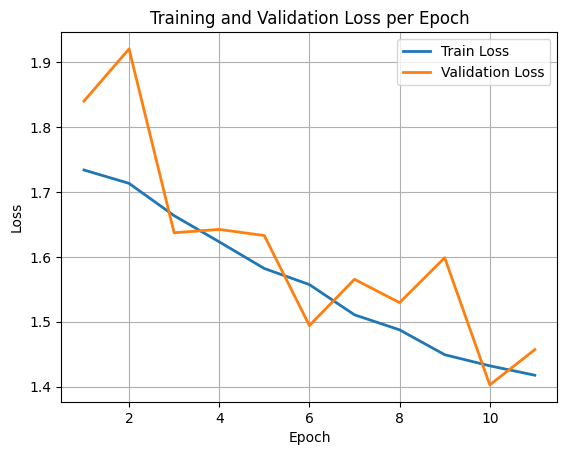

No improvement for 1 epochs.
Epoch 12/400 - Train Loss: 1.3949 - Val Loss: 1.5013 - LR: 0.020000
No improvement for 2 epochs.
Epoch 13/400 - Train Loss: 1.3887 - Val Loss: 1.3550 - LR: 0.020000
Epoch 14/400 - Train Loss: 1.3629 - Val Loss: 1.5562 - LR: 0.020000
No improvement for 1 epochs.
Epoch 15/400 - Train Loss: 1.3749 - Val Loss: 1.3505 - LR: 0.020000
Epoch 16/400 - Train Loss: 1.3378 - Val Loss: 1.3252 - LR: 0.020000
Epoch 17/400 - Train Loss: 1.3378 - Val Loss: 1.3285 - LR: 0.020000
No improvement for 1 epochs.
Epoch 18/400 - Train Loss: 1.3507 - Val Loss: 1.4910 - LR: 0.020000
No improvement for 2 epochs.
Epoch 19/400 - Train Loss: 1.3023 - Val Loss: 1.2625 - LR: 0.020000
Epoch 20/400 - Train Loss: 1.3009 - Val Loss: 1.3111 - LR: 0.020000
No improvement for 1 epochs.
Epoch 21/400 - Train Loss: 1.2938 - Val Loss: 1.3139 - LR: 0.020000
Accuracy: 0.4914
              precision    recall  f1-score   support

           0       0.52      0.23      0.32       524
           1       0

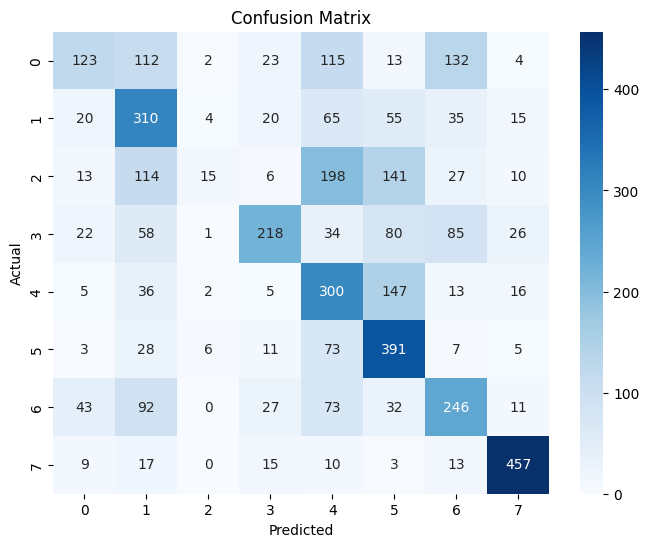

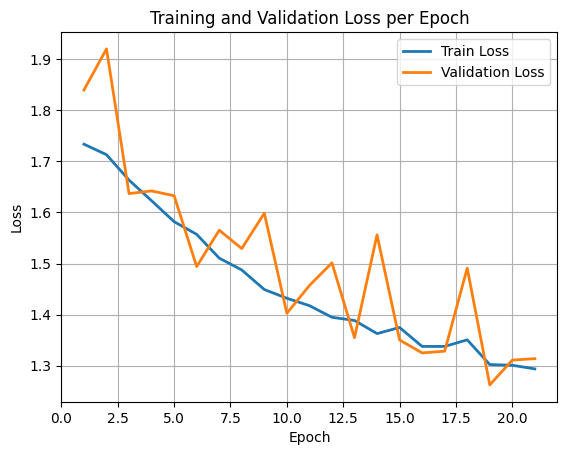

No improvement for 2 epochs.
Epoch 22/400 - Train Loss: 1.2923 - Val Loss: 1.2923 - LR: 0.020000
No improvement for 3 epochs.
Epoch 23/400 - Train Loss: 1.2675 - Val Loss: 1.2360 - LR: 0.020000
Epoch 24/400 - Train Loss: 1.2747 - Val Loss: 1.2524 - LR: 0.020000
No improvement for 1 epochs.
Epoch 25/400 - Train Loss: 1.2589 - Val Loss: 1.2497 - LR: 0.020000
No improvement for 2 epochs.
Epoch 26/400 - Train Loss: 1.2483 - Val Loss: 1.3071 - LR: 0.020000
No improvement for 3 epochs.
Epoch 27/400 - Train Loss: 1.2517 - Val Loss: 1.3450 - LR: 0.010000
No improvement for 4 epochs.
Epoch 28/400 - Train Loss: 1.1513 - Val Loss: 1.1090 - LR: 0.010000
Epoch 29/400 - Train Loss: 1.0948 - Val Loss: 1.0588 - LR: 0.010000
Epoch 30/400 - Train Loss: 1.0885 - Val Loss: 1.0836 - LR: 0.010000
No improvement for 1 epochs.
Epoch 31/400 - Train Loss: 1.0755 - Val Loss: 1.0483 - LR: 0.010000
Accuracy: 0.5503
              precision    recall  f1-score   support

           0       0.57      0.39      0.46  

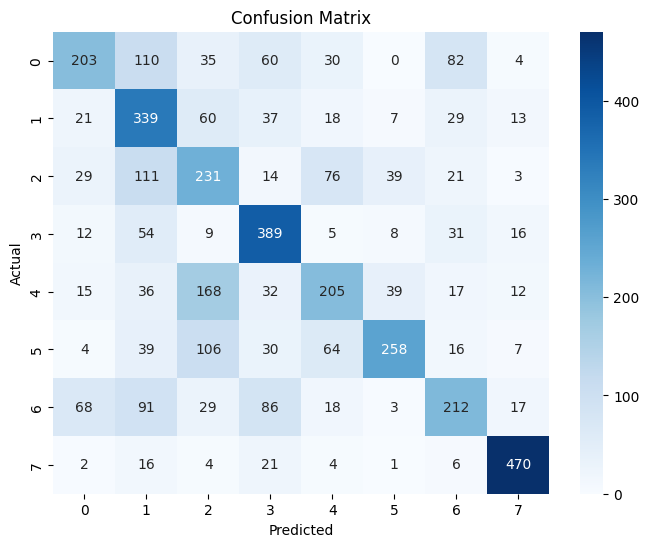

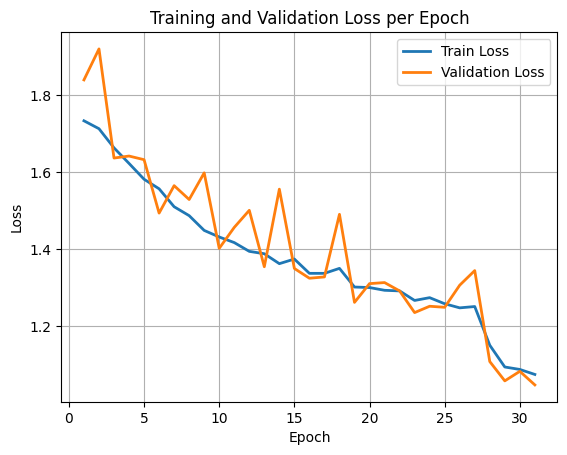

Epoch 32/400 - Train Loss: 1.0671 - Val Loss: 1.0382 - LR: 0.010000
Epoch 33/400 - Train Loss: 1.0553 - Val Loss: 1.0856 - LR: 0.010000
No improvement for 1 epochs.
Epoch 34/400 - Train Loss: 1.0574 - Val Loss: 1.0694 - LR: 0.010000
No improvement for 2 epochs.
Epoch 35/400 - Train Loss: 1.0393 - Val Loss: 1.0619 - LR: 0.010000
No improvement for 3 epochs.
Epoch 36/400 - Train Loss: 1.0385 - Val Loss: 1.0899 - LR: 0.005000
No improvement for 4 epochs.
Epoch 37/400 - Train Loss: 0.9601 - Val Loss: 0.9404 - LR: 0.005000
Epoch 38/400 - Train Loss: 0.9407 - Val Loss: 0.9066 - LR: 0.005000
Epoch 39/400 - Train Loss: 0.9293 - Val Loss: 0.9324 - LR: 0.005000
No improvement for 1 epochs.
Epoch 40/400 - Train Loss: 0.9300 - Val Loss: 0.8939 - LR: 0.005000
Epoch 41/400 - Train Loss: 0.9067 - Val Loss: 0.8840 - LR: 0.005000
Accuracy: 0.5890
              precision    recall  f1-score   support

           0       0.54      0.49      0.51       524
           1       0.56      0.50      0.53      

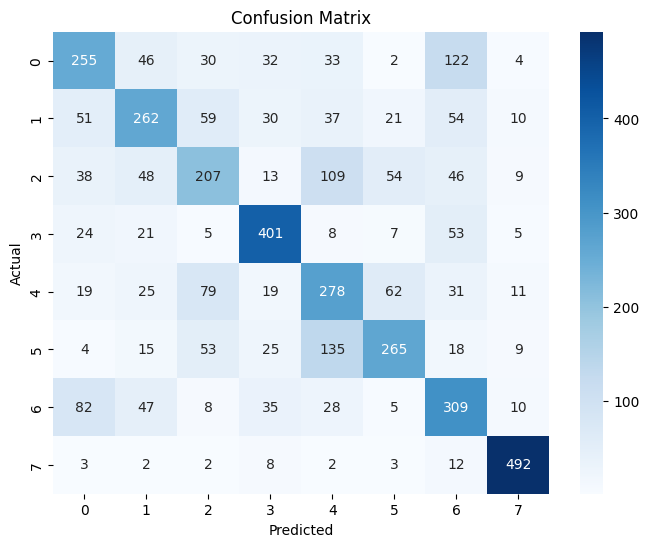

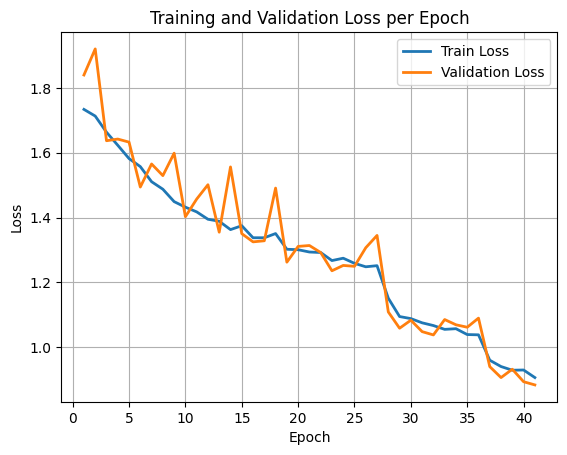

Epoch 42/400 - Train Loss: 0.8998 - Val Loss: 0.8959 - LR: 0.005000
No improvement for 1 epochs.
Epoch 43/400 - Train Loss: 0.8963 - Val Loss: 0.8577 - LR: 0.005000
Epoch 44/400 - Train Loss: 0.8854 - Val Loss: 0.8907 - LR: 0.005000
No improvement for 1 epochs.
Epoch 45/400 - Train Loss: 0.8891 - Val Loss: 0.8772 - LR: 0.005000
No improvement for 2 epochs.
Epoch 46/400 - Train Loss: 0.8718 - Val Loss: 0.8925 - LR: 0.005000
No improvement for 3 epochs.
Epoch 47/400 - Train Loss: 0.8591 - Val Loss: 0.8924 - LR: 0.002500
No improvement for 4 epochs.
Epoch 48/400 - Train Loss: 0.8197 - Val Loss: 0.8211 - LR: 0.002500
Epoch 49/400 - Train Loss: 0.8095 - Val Loss: 0.7984 - LR: 0.002500
Epoch 50/400 - Train Loss: 0.8012 - Val Loss: 0.7919 - LR: 0.002500
Epoch 51/400 - Train Loss: 0.7972 - Val Loss: 0.7960 - LR: 0.002500
Accuracy: 0.5969
              precision    recall  f1-score   support

           0       0.52      0.58      0.55       524
           1       0.51      0.56      0.54      

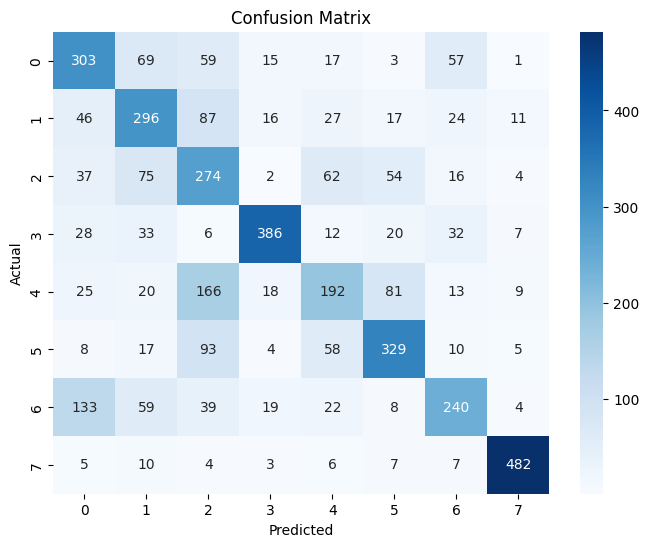

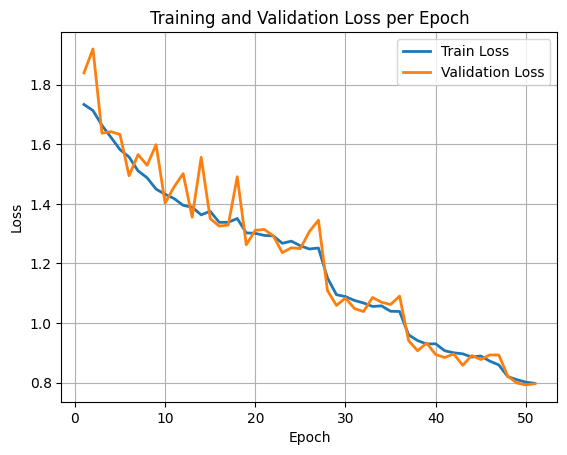

No improvement for 1 epochs.
Epoch 52/400 - Train Loss: 0.7835 - Val Loss: 0.7894 - LR: 0.002500
Epoch 53/400 - Train Loss: 0.7807 - Val Loss: 0.7795 - LR: 0.002500
Epoch 54/400 - Train Loss: 0.7766 - Val Loss: 0.7500 - LR: 0.002500
Epoch 55/400 - Train Loss: 0.7737 - Val Loss: 0.7925 - LR: 0.002500
No improvement for 1 epochs.
Epoch 56/400 - Train Loss: 0.7688 - Val Loss: 0.7428 - LR: 0.002500
Epoch 57/400 - Train Loss: 0.7568 - Val Loss: 0.7715 - LR: 0.002500
No improvement for 1 epochs.
Epoch 58/400 - Train Loss: 0.7638 - Val Loss: 0.7461 - LR: 0.002500
No improvement for 2 epochs.
Epoch 59/400 - Train Loss: 0.7434 - Val Loss: 0.7637 - LR: 0.002500
No improvement for 3 epochs.
Epoch 60/400 - Train Loss: 0.7458 - Val Loss: 0.7433 - LR: 0.001250
No improvement for 4 epochs.
Epoch 61/400 - Train Loss: 0.7171 - Val Loss: 0.7116 - LR: 0.001250
Accuracy: 0.6240
              precision    recall  f1-score   support

           0       0.60      0.56      0.58       524
           1       0

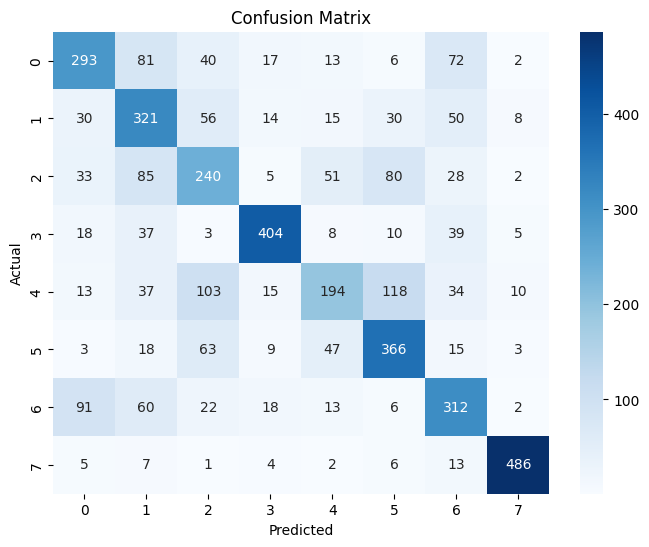

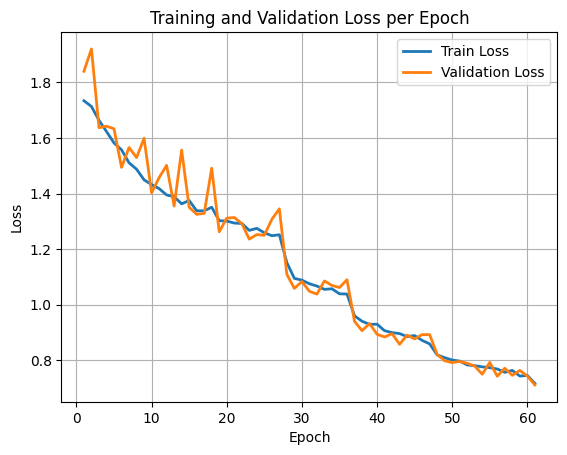

Epoch 62/400 - Train Loss: 0.7085 - Val Loss: 0.6984 - LR: 0.001250
Epoch 63/400 - Train Loss: 0.6975 - Val Loss: 0.6960 - LR: 0.001250
Epoch 64/400 - Train Loss: 0.6999 - Val Loss: 0.7153 - LR: 0.001250
No improvement for 1 epochs.
Epoch 65/400 - Train Loss: 0.7036 - Val Loss: 0.6889 - LR: 0.001250
Epoch 66/400 - Train Loss: 0.6917 - Val Loss: 0.6834 - LR: 0.001250
Epoch 67/400 - Train Loss: 0.6906 - Val Loss: 0.6701 - LR: 0.001250
Epoch 68/400 - Train Loss: 0.6877 - Val Loss: 0.6737 - LR: 0.001250
No improvement for 1 epochs.
Epoch 69/400 - Train Loss: 0.6861 - Val Loss: 0.6709 - LR: 0.001250
No improvement for 2 epochs.
Epoch 70/400 - Train Loss: 0.6786 - Val Loss: 0.6822 - LR: 0.001250
No improvement for 3 epochs.
Epoch 71/400 - Train Loss: 0.6734 - Val Loss: 0.6661 - LR: 0.001250
Accuracy: 0.6298
              precision    recall  f1-score   support

           0       0.59      0.61      0.60       524
           1       0.56      0.59      0.57       524
           2       0.44 

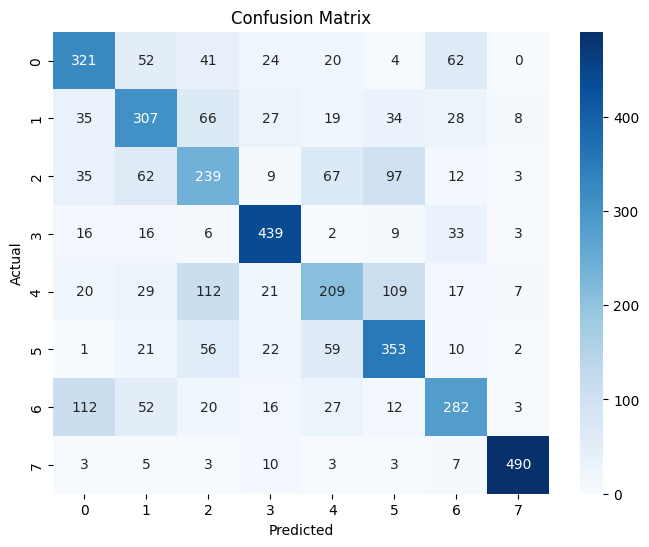

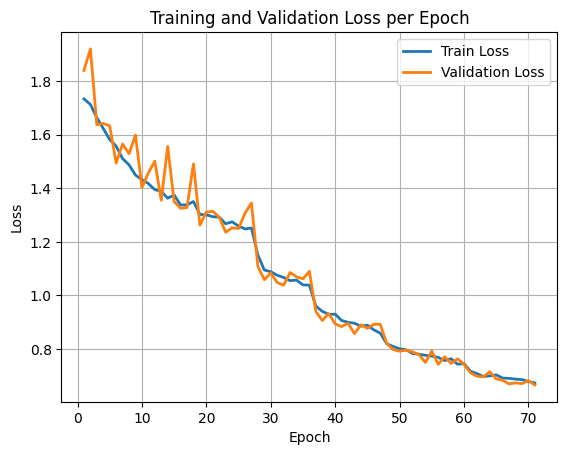

Epoch 72/400 - Train Loss: 0.6702 - Val Loss: 0.6715 - LR: 0.001250
No improvement for 1 epochs.
Epoch 73/400 - Train Loss: 0.6743 - Val Loss: 0.6686 - LR: 0.001250
No improvement for 2 epochs.
Epoch 74/400 - Train Loss: 0.6666 - Val Loss: 0.6633 - LR: 0.001250
Epoch 75/400 - Train Loss: 0.6653 - Val Loss: 0.6621 - LR: 0.001250
Epoch 76/400 - Train Loss: 0.6587 - Val Loss: 0.6729 - LR: 0.001250
No improvement for 1 epochs.
Epoch 77/400 - Train Loss: 0.6601 - Val Loss: 0.6287 - LR: 0.001250
Epoch 78/400 - Train Loss: 0.6499 - Val Loss: 0.6547 - LR: 0.001250
No improvement for 1 epochs.
Epoch 79/400 - Train Loss: 0.6436 - Val Loss: 0.6233 - LR: 0.001250
Epoch 80/400 - Train Loss: 0.6493 - Val Loss: 0.6367 - LR: 0.001250
No improvement for 1 epochs.
Epoch 81/400 - Train Loss: 0.6417 - Val Loss: 0.6397 - LR: 0.001250
Accuracy: 0.6310
              precision    recall  f1-score   support

           0       0.58      0.59      0.58       524
           1       0.51      0.64      0.57      

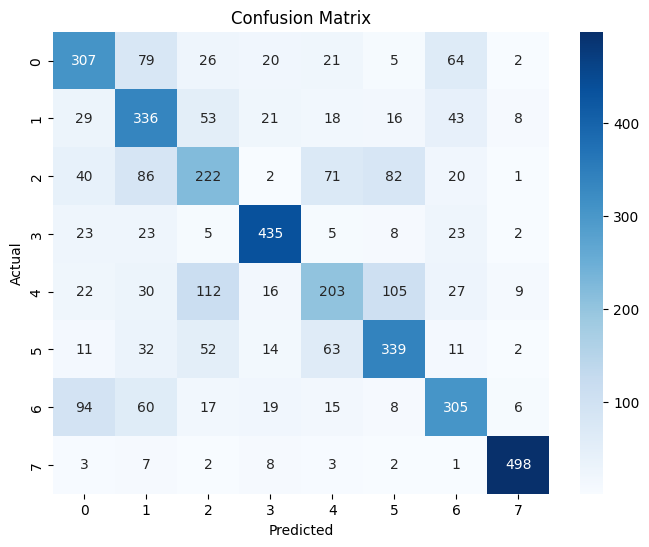

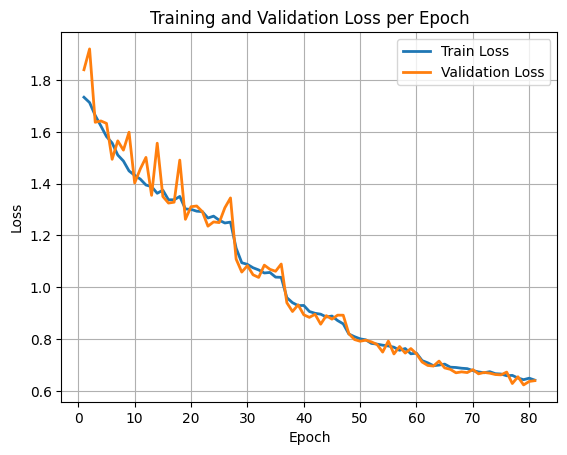

No improvement for 2 epochs.
Epoch 82/400 - Train Loss: 0.6361 - Val Loss: 0.6452 - LR: 0.001250
No improvement for 3 epochs.
Epoch 83/400 - Train Loss: 0.6435 - Val Loss: 0.6557 - LR: 0.000625
No improvement for 4 epochs.
Epoch 84/400 - Train Loss: 0.6222 - Val Loss: 0.6290 - LR: 0.000625
No improvement for 5 epochs.
Epoch 85/400 - Train Loss: 0.6161 - Val Loss: 0.6318 - LR: 0.000625
No improvement for 6 epochs.
Epoch 86/400 - Train Loss: 0.6115 - Val Loss: 0.6253 - LR: 0.000625
No improvement for 7 epochs.
Epoch 87/400 - Train Loss: 0.6099 - Val Loss: 0.6198 - LR: 0.000625
Epoch 88/400 - Train Loss: 0.6159 - Val Loss: 0.6075 - LR: 0.000625
Epoch 89/400 - Train Loss: 0.6109 - Val Loss: 0.6038 - LR: 0.000625
Epoch 90/400 - Train Loss: 0.6046 - Val Loss: 0.6158 - LR: 0.000625
No improvement for 1 epochs.
Epoch 91/400 - Train Loss: 0.6090 - Val Loss: 0.6134 - LR: 0.000625
Accuracy: 0.6264
              precision    recall  f1-score   support

           0       0.60      0.58      0.59  

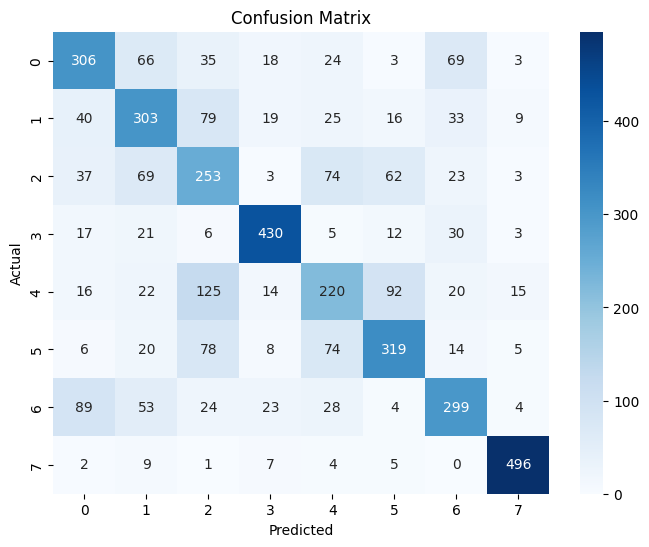

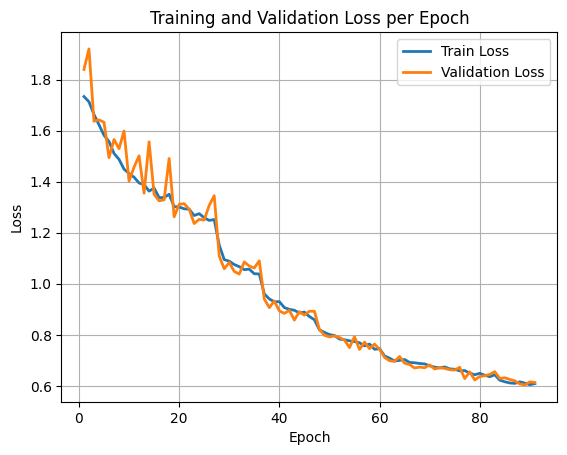

No improvement for 2 epochs.
Epoch 92/400 - Train Loss: 0.6008 - Val Loss: 0.6076 - LR: 0.000625
No improvement for 3 epochs.
Epoch 93/400 - Train Loss: 0.5944 - Val Loss: 0.6062 - LR: 0.000313
No improvement for 4 epochs.


In [ ]:
num_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)
num_epochs = 400

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for batch_image_class, batch_image_tensor in train_dataloader:
        batch_image_tensor, batch_image_class = batch_image_tensor.to(
            device
        ), batch_image_class.to(device)

        optimizer.zero_grad()
        outputs = model(batch_image_tensor)
        loss = loss_func(outputs, batch_image_class)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / num_batches
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_image_class, val_image_tensor in val_dataloader:
            val_image_tensor, val_image_class = val_image_tensor.to(
                device
            ), val_image_class.to(device)
            val_outputs = model(val_image_tensor)
            val_loss = loss_func(val_outputs, val_image_class)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / num_val_batches
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    current_lr = scheduler.get_last_lr()[0]
    print(
        f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - LR: {current_lr:.6f}"
    )

    if epoch % 10 == 0:
        display_evaluation_metrics()
        plot_training_loss(epoch+1, val_losses, train_losses)

    # Early stopping rule
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs.")

    if patience_counter >= patience_limit:
        num_epochs = epoch
        print("Early stopping triggered. Terminating training.")
        break